#  On the relationship between El Niño/La Niña and Droughts in East Africa

"Every five or so years, [...] a La Niña weather cycle brings devastating drought and hunger to East Africa"
(see ["Ethiopia, Somalia and Kenya face devastating drought"](https://www.nature.com/articles/d41586-020-02698-3), Nature, 15 October 2020).  

This notebook examines the relationship between La Niña and droughts in the region using data from [Gro](https://app.gro-intelligence.com). The data used here can be inspected in [this display on Gro](https://app.gro-intelligence.com/displays/3dW3V6zdD).

In [1]:
import os
from groclient import client

client = client.GroClient('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

## Drought

There are many data series related to drought:

- the Gro Drought Index (GDI) is available at the district and province level, daily and weekly. 
- a less precise evapotranspiration-only based drought indicator is available monthly at the country level. 

For simplicity, let us add the weekly GDI series at the province level.

In [2]:
for country in ['Ethiopia', 'Kenya', 'Somalia']:
    country_id = client.search_for_entity('regions', country)
    for region in client.get_descendant_regions(country_id, 4):   
        for series in client.get_data_series(item_id=17388, metric_id=15852252, frequency_id=2, region_id=region['id']):
            client.add_single_data_series(series)

## El Niño & La Niña 

The El Niño-Southern Oscillation (ENSO) data series captures the El Niño/La Niña cycle, which is global.

In [3]:
client.add_data_series(item = "Multivariate ENSO Index", metric="El Niño Southern Oscillation Index")

{'metric_id': 15851977,
 'metric_name': 'El Niño Southern Oscillation Index',
 'item_id': 13495,
 'item_name': 'Multivariate ENSO Index',
 'region_id': 0,
 'region_name': 'World',
 'partner_region_id': 0,
 'partner_region_name': 'World',
 'frequency_id': 6,
 'frequency_name': 'monthly',
 'source_id': 124,
 'source_name': 'NOAA MEI v2',
 'start_date': '1979-01-01T00:00:00.000Z',
 'end_date': '2020-09-30T00:00:00.000Z',
 'data_count_estimate': 509}

In [4]:
import pandas as pd

df = client.get_df()
print(df.shape)

(43089, 13)


For a simple approximation, we convert the weekly data to monthly and average each series across the whole region. Note the temporal aggregation is just an aggregation, but the spatial aspect is a bit imprecise as it gives equal weight to all provinces instead of weighting them by area.

In [5]:
all_monthly_series = []

for group, series_df in df.groupby(['item_id', 'metric_id']):
    mmdf = series_df.set_index('end_date').groupby(pd.Grouper(freq="M")).mean()
    all_monthly_series.append((group, mmdf))
    print(group, mmdf.shape)

(13495, 15851977) (501, 10)
(17388, 15852252) (130, 10)


/home/nemo/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/nemo/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


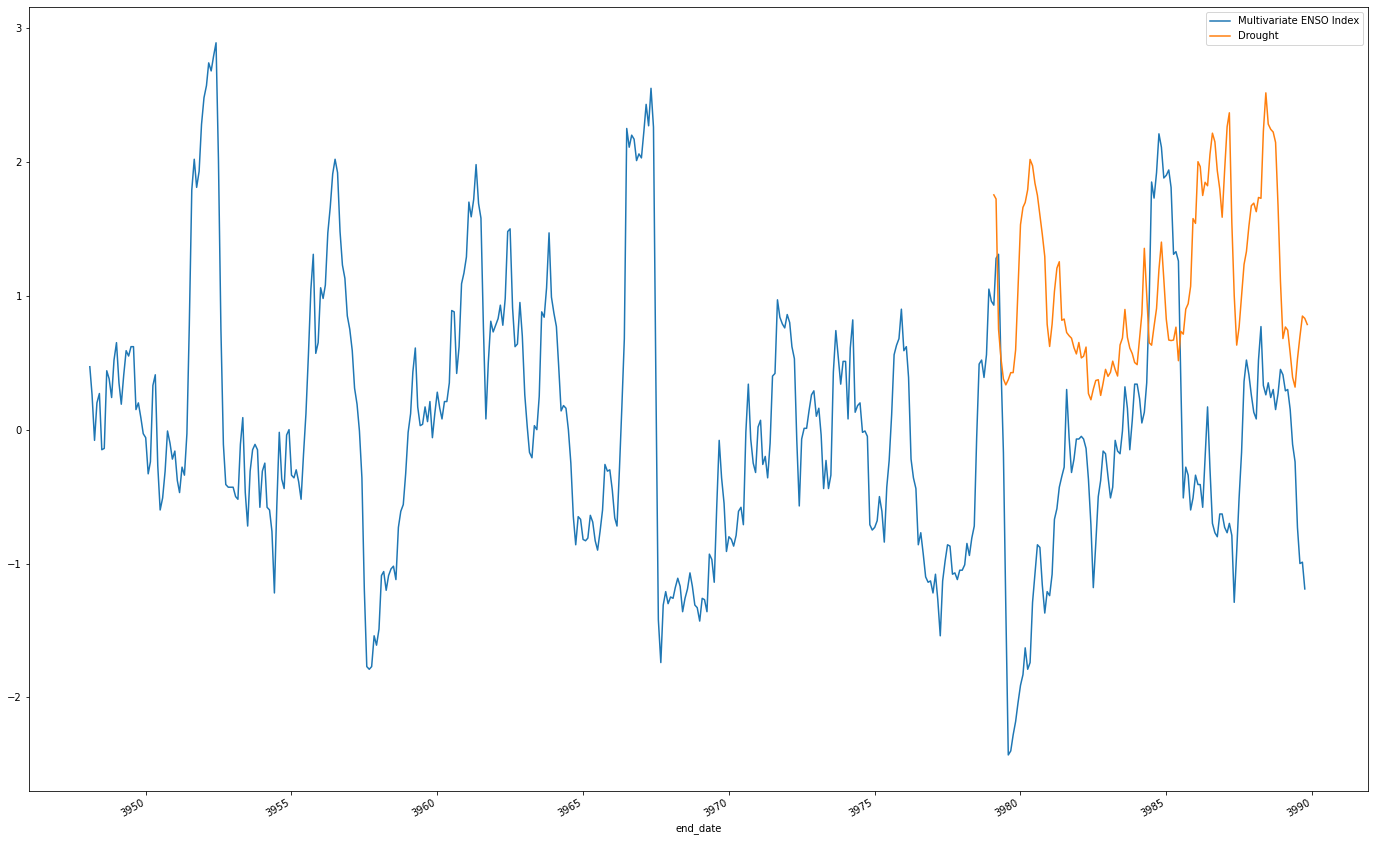

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(24,16))

for g,s in all_monthly_series:
    s.plot(y='value', ax=axes, x_compat=True,
          label="{}".format(client.lookup('items', g[0])['name']))

## Analysis

<AxesSubplot:xlabel='Multivariate ENSO Index', ylabel='Drought'>

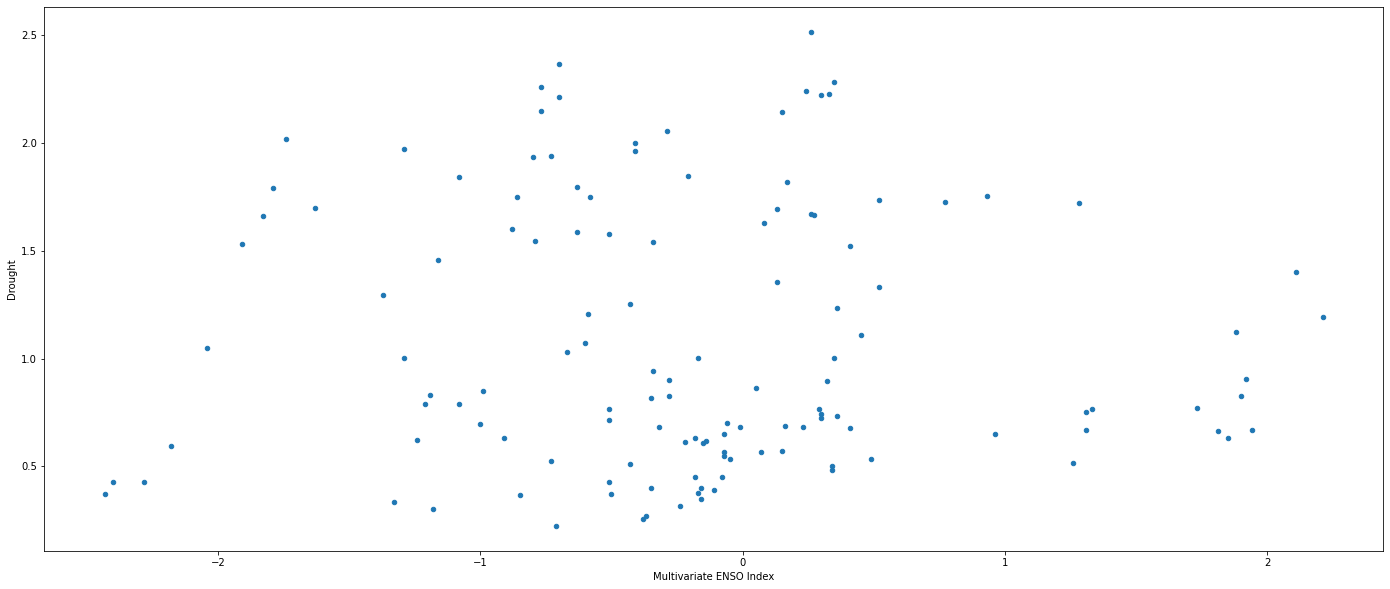

In [7]:
sdf = None

for g, s in all_monthly_series:
    item_name = client.lookup('items', g[0])['name']
    d = s.rename(mapper={'value': item_name}, axis='columns')[[item_name]]
    if sdf is None:
        sdf = d
    else:
        sdf = sdf.join(d, on=['end_date'], how='inner')

fig, axes = plt.subplots(1,1, figsize=(24,10))
sdf.plot.scatter(x='Multivariate ENSO Index', y='Drought', ax=axes)
